In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install transformers
import transformers
import torch
import torch.nn as nn

# New Section

# New Section

In [ ]:
from tqdm import tqdm
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
DEVICE = "cuda"
MAX_LEN=64
TRAIN_BATCH_SIZE=64
VALID_BATCH_SIZE=64
TEST_BATCH_SIZE=64
EPOCHS=2
MODEL_PATH = "./model_BERT.bin"
BERT_PRE_TRAINED_MODEL = "bert-base-uncased"
TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PRE_TRAINED_MODEL)

In [ ]:
train = pd.read_csv('/content/train.csv',engine='python', error_bad_lines=False,names=['label','title','text'])
train['review'] = train[['title', 'text']].astype(str).apply(' '.join, axis=1)
train.drop('title', axis=1, inplace=True)
train.drop('text', axis=1, inplace=True)
train

Skipping line 2421411: unexpected end of data


,label,review
0,2,Stuning even for the non-gamer This sound trac...
1,2,The best soundtrack ever to anything. I'm read...
2,2,Amazing! This soundtrack is my favorite music ...
3,2,Excellent Soundtrack I truly like this soundtr...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
2421405,1,Scarecrows is a near 'miss' with few scares I ...
2421406,1,"It's not an Uncut Unrated Restore Version, thi..."
2421407,1,haven't watched it I ordered this movie for a ...
2421408,1,Baaaaaaaaaaaaaaaaad Sooooooooooo pointless and...


In [ ]:
test = pd.read_csv('/content/test.csv',engine='python',error_bad_lines=False,names=['label','title','text'])
test['review'] = test[['title', 'text']].astype(str).apply(' '.join, axis=1)
test.drop('title', axis=1, inplace=True)
test.drop('text', axis=1, inplace=True)
test

,label,review
0,2,Great CD My lovely Pat has one of the GREAT vo...
1,2,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ... I bought this...
3,2,"works fine, but Maha Energy is better Check ou..."
4,2,Great for the non-audiophile Reviewed quite a ...
...,...,...
399995,1,Unbelievable- In a Bad Way We bought this Thom...
399996,1,"Almost Great, Until it Broke... My son recieve..."
399997,1,Disappointed !!! I bought this toy for my son ...
399998,2,Classic Jessica Mitford This is a compilation ...


In [ ]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train, test_size=0.15, random_state=42)
valid

,label,review
2024740,1,These gloves are horrible I bought these for m...
1308502,1,Fire in the Heart As this was a gift and I hav...
1763733,1,"Why? Sorry, but this just doesn't cut it. The ..."
390193,2,"My life transformed As an archiecture student,..."
2216687,1,So Strange I like costume movies and thought t...
...,...,...
1457534,1,Rather dull and weak follow-up to the first. T...
567153,1,"Superficial, hardly any practical value The bo..."
2277281,1,Flat Flat World A friend recommended this book...
1426653,1,"God, I hated this book It's rare that I come a..."


In [ ]:
test['label'].replace({2: 0}, inplace=True)

In [ ]:
train['label'].replace({2: 0}, inplace=True)
valid['label'].replace({2: 0}, inplace=True)

In [ ]:
class Dataset:
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
train_dataset = Dataset(reviews=train.review.values, targets=train.label.values,tokenizer=TOKENIZER,
                            max_len=MAX_LEN)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4)

In [ ]:
valid_dataset = Dataset(reviews=valid.review.values, targets=valid.label.values,tokenizer=TOKENIZER,
                            max_len=MAX_LEN)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=1)

In [ ]:
class BERTBaseUncasedClassifier(nn.Module):
    def __init__(self,n_classes):
        super(BERTBaseUncasedClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_PRE_TRAINED_MODEL)
        self.bert_drop = nn.Dropout(0.3) #Regularization
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) #Fully connected Layer

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.bert_drop(pooled_output)
        return self.out(output)

In [ ]:
device = torch.device(DEVICE)
model = BERTBaseUncasedClassifier(2)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTBaseUncasedClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
print("Length of Train Data Loader: ",len(train_data_loader))
print("Total Steps: ",total_steps)
print("Epochs: ",EPOCHS)

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

Length of Train Data Loader:  32160
Total Steps:  64320
Epochs:  2


In [ ]:
from sklearn.metrics import f1_score
def f1_score_func(predictedValues, trueValues):
    preds = predictedValues.cpu().detach().numpy()
    true = trueValues.cpu().flatten()
    return f1_score(true, preds, average = 'weighted')

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for bi, d in tqdm(enumerate(data_loader),total=len(data_loader)):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    train_f1 = f1_score_func(preds, targets)

    return train_f1, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader),total=len(data_loader)):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

    val_f1 = f1_score_func(preds, targets)

    return val_f1, np.mean(losses)

In [ ]:
train_len = len(train)

In [ ]:
valid_len = len(valid)
valid_len

363212

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        train_len
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    valid_data_loader,
    loss_fn,
    device,
    valid_len
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    checkpoint = {'model': BERTBaseUncasedClassifier(2),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
    
    torch.save(checkpoint, 'checkpoint.pth')
           
    if val_acc > best_accuracy:
        #torch.save(model.state_dict(), 'best_model_state.bin')
        torch.save(model.state_dict(), MODEL_PATH)
        best_accuracy = val_acc

Epoch 1/2
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.18303093490836356 accuracy 0.9



100%|██████████| 449/449 [03:15<00:00,  2.30it/s]


Val   loss 0.14355945953879432 accuracy 1.0



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 2/2
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.10287387803802157 accuracy 0.9005714285714285



100%|██████████| 449/449 [03:16<00:00,  2.29it/s]


Val   loss 0.1587923219000178 accuracy 0.9735914839954006



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


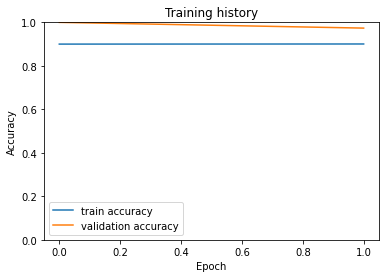

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_dataset = Dataset(reviews=test.review.values, targets=test.label.values,tokenizer=TOKENIZER,
                            max_len=MAX_LEN)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=4)

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)            
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,
                attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
          #  review_texts.extend(texts)
            predictions.extend(preds)
         #   prediction_probs.extend(outputs)
            real_values.extend(targets)
        predictions = torch.stack(predictions).cpu()
        #prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
    return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(model,test_data_loader)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
test_f1 = f1_score_func(y_pred, y_test)
print(f'Test set F-Score {test_f1}')

Test set F-Score 0.9455566253975067
